# World CO2 Emissions Forecasting
## Fitting an ARIMA Model
[*Cristian Castro Álvarez*](https://github.com/cristian-castro-a)

**Goal**: 
- To fit an ARIMA Model to the World CO2 Emissions


**Data:**
- The data comes from [Our World in Data](https://github.com/owid/co2-data)
- Column 'CO2' of the dataframe indicates the Tonnes of CO2 emmitted into the atmosphere.
- The dataset includes yearly data from 1750 to 2020, with a total of 271 data points.

In [1]:
# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm

from sklearn.metrics import mean_absolute_error

import warnings
warnings.filterwarnings("ignore")

## Data

In [2]:
df = pd.read_csv('../Data/owid-co2-data.csv')
df.head()

,iso_code,country,year,co2,co2_per_capita,trade_co2,cement_co2,cement_co2_per_capita,coal_co2,coal_co2_per_capita,...,ghg_excluding_lucf_per_capita,methane,methane_per_capita,nitrous_oxide,nitrous_oxide_per_capita,population,gdp,primary_energy_consumption,energy_per_capita,energy_per_gdp
0,AFG,Afghanistan,1949,0.015,0.002,NaN,NaN,NaN,0.015,0.002,...,NaN,NaN,NaN,NaN,NaN,7624058.0,NaN,NaN,NaN,NaN
1,AFG,Afghanistan,1950,0.084,0.011,NaN,NaN,NaN,0.021,0.003,...,NaN,NaN,NaN,NaN,NaN,7752117.0,9.421400e+09,NaN,NaN,NaN
2,AFG,Afghanistan,1951,0.092,0.012,NaN,NaN,NaN,0.026,0.003,...,NaN,NaN,NaN,NaN,NaN,7840151.0,9.692280e+09,NaN,NaN,NaN
3,AFG,Afghanistan,1952,0.092,0.012,NaN,NaN,NaN,0.032,0.004,...,NaN,NaN,NaN,NaN,NaN,7935996.0,1.001732e+10,NaN,NaN,NaN
4,AFG,Afghanistan,1953,0.106,0.013,NaN,NaN,NaN,0.038,0.005,...,NaN,NaN,NaN,NaN,NaN,8039684.0,1.063052e+10,NaN,NaN,NaN


In [3]:
df.columns

Index(['iso_code', 'country', 'year', 'co2', 'co2_per_capita', 'trade_co2',
       'cement_co2', 'cement_co2_per_capita', 'coal_co2',
       'coal_co2_per_capita', 'flaring_co2', 'flaring_co2_per_capita',
       'gas_co2', 'gas_co2_per_capita', 'oil_co2', 'oil_co2_per_capita',
       'other_industry_co2', 'other_co2_per_capita', 'co2_growth_prct',
       'co2_growth_abs', 'co2_per_gdp', 'co2_per_unit_energy',
       'consumption_co2', 'consumption_co2_per_capita',
       'consumption_co2_per_gdp', 'cumulative_co2', 'cumulative_cement_co2',
       'cumulative_coal_co2', 'cumulative_flaring_co2', 'cumulative_gas_co2',
       'cumulative_oil_co2', 'cumulative_other_co2', 'trade_co2_share',
       'share_global_co2', 'share_global_cement_co2', 'share_global_coal_co2',
       'share_global_flaring_co2', 'share_global_gas_co2',
       'share_global_oil_co2', 'share_global_other_co2',
       'share_global_cumulative_co2', 'share_global_cumulative_cement_co2',
       'share_global_cumulative_c

In [4]:
# Let's aggregate the data yearly.
df = df.groupby(by=['year']).sum().reset_index()[['year','co2']]
df.insert(loc = 1, column = 'month', value = 12)
df.insert(loc = 2, column = 'day', value = 31)
values = pd.to_datetime(df[['year','month','day']])
df.insert(loc = 0, column = 'date', value = values)
df.drop(['year','month','day'], axis = 1, inplace = True)
df.set_index('date', inplace = True)
df.head()

,co2
date,
1750-12-31,46.755
1751-12-31,46.755
1752-12-31,46.770
1753-12-31,46.770
1754-12-31,46.790


In [5]:
# To work with tonnes of CO2 it is necessary a conversion factor of 3.664.
df['co2'] = df['co2']/3.664
df.tail().round(1)

,co2
date,
2016-12-31,34035.4
2017-12-31,34471.8
2018-12-31,35058.0
2019-12-31,35049.9
2020-12-31,33185.8


In [6]:
df.shape

(271, 1)

In [7]:
df.isna().sum()

co2    0
dtype: int64

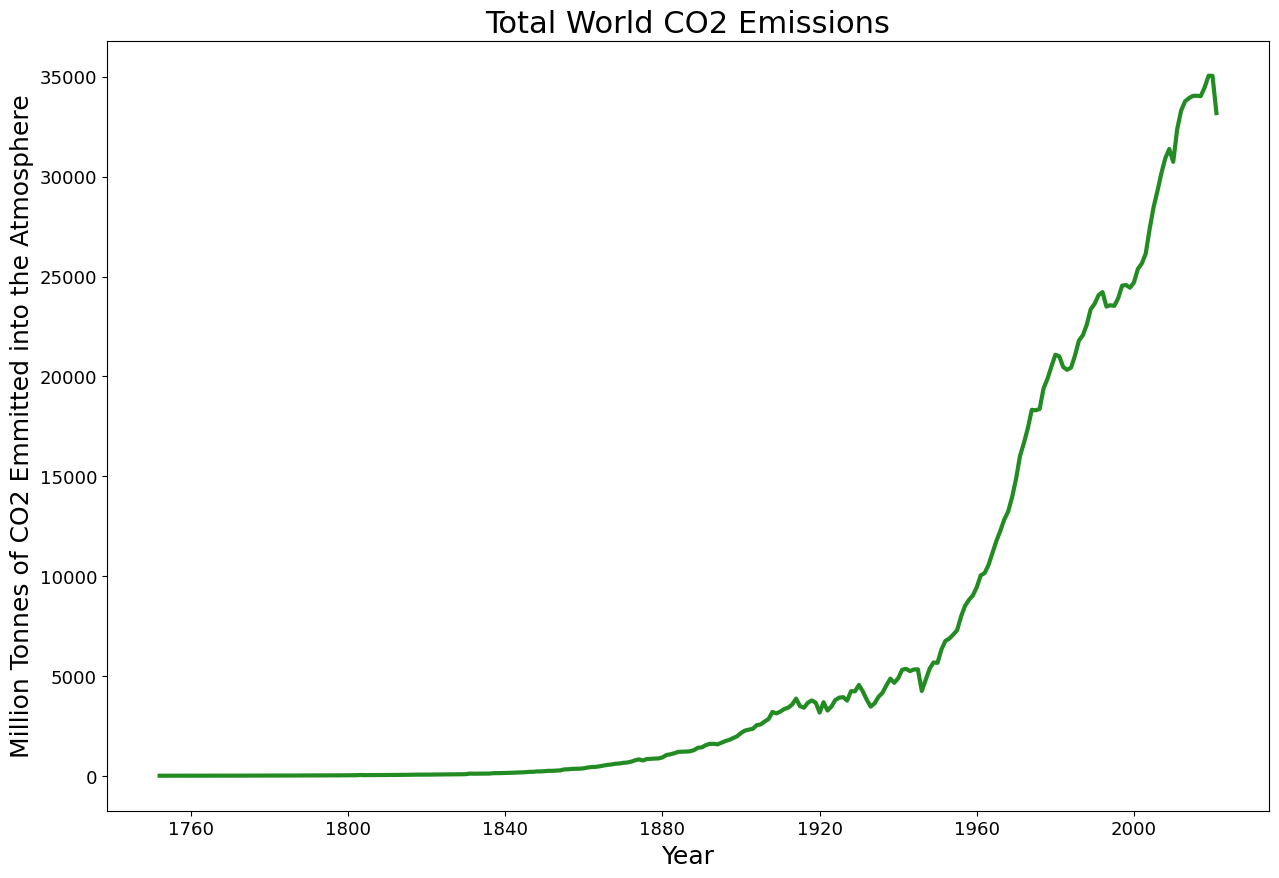

In [8]:
# Visualizing the yearly emission and its trend
plt.figure(figsize = (15,10))
plt.plot(df.iloc[1:],
         linewidth = 3,
         color = 'forestgreen')
plt.title('Total World CO2 Emissions', fontsize = 22)
plt.xlabel('Year', fontsize = 18)
plt.ylabel('Million Tonnes of CO2 Emmitted into the Atmosphere', fontsize = 18)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.show()

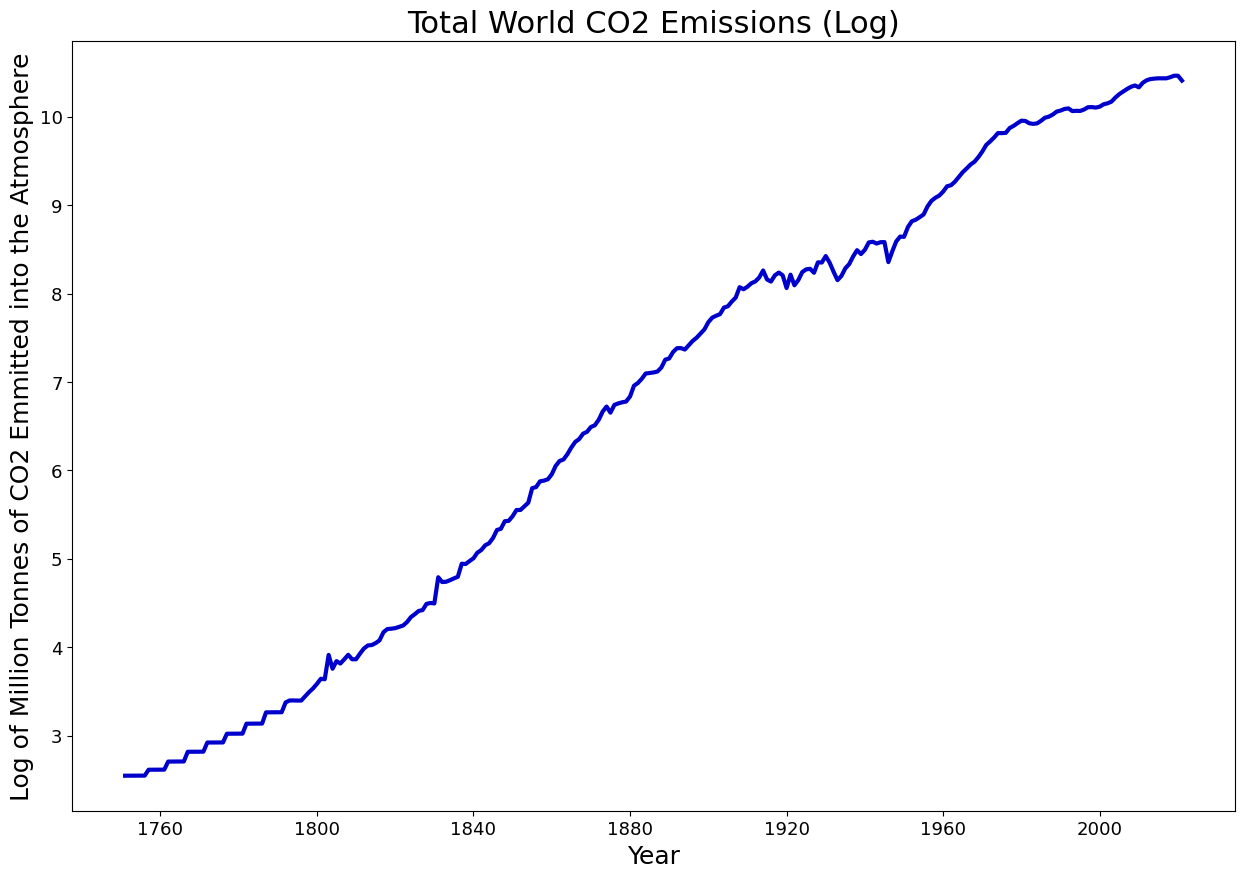

In [9]:
# Visualizing the yearly emission and its trend (in Log transform)
plt.figure(figsize = (15,10))
plt.plot(np.log(df['co2']),
         linewidth = 3,
         color = 'mediumblue')
plt.title('Total World CO2 Emissions (Log)', fontsize = 22)
plt.xlabel('Year', fontsize = 18)
plt.ylabel('Log of Million Tonnes of CO2 Emmitted into the Atmosphere', fontsize = 18)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.show()

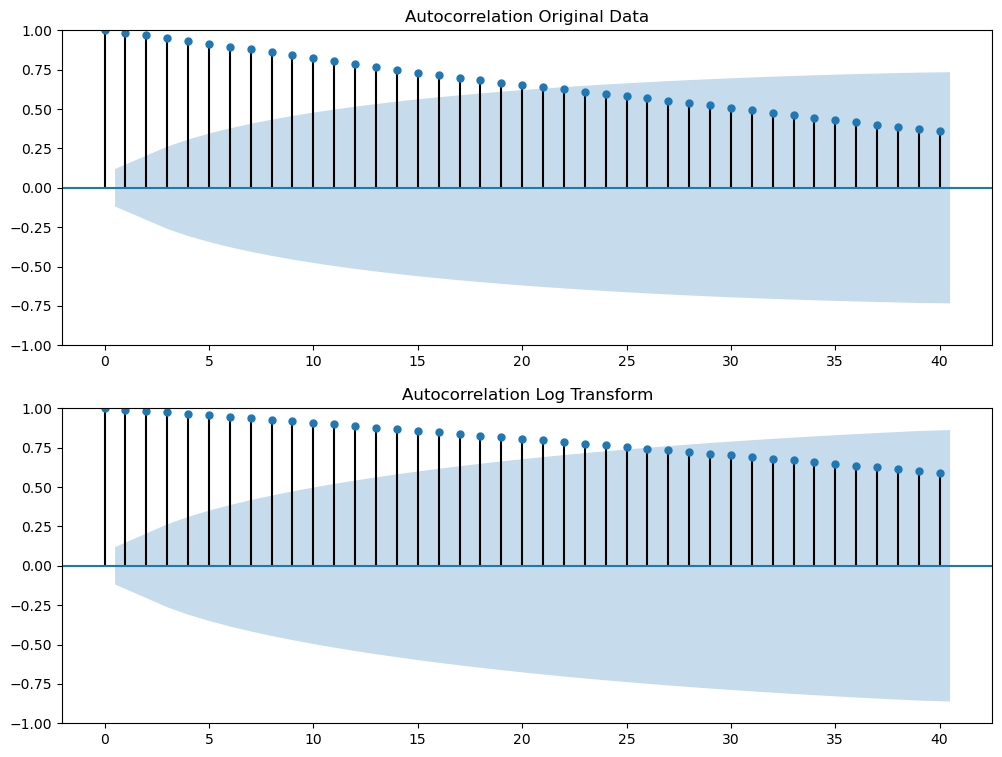

In [10]:
# Let's check for autocorrelation.
fig = plt.figure(figsize = (12,9))
ax1 = fig.add_subplot(211)
fig = plot_acf(x = df, 
               lags=40, 
               ax=ax1)
ax1.title.set_text('Autocorrelation Original Data')
ax2 = fig.add_subplot(212)
fig = plot_acf(x = np.log(df), 
               lags=40, 
               ax=ax2)
ax2.title.set_text('Autocorrelation Log Transform')

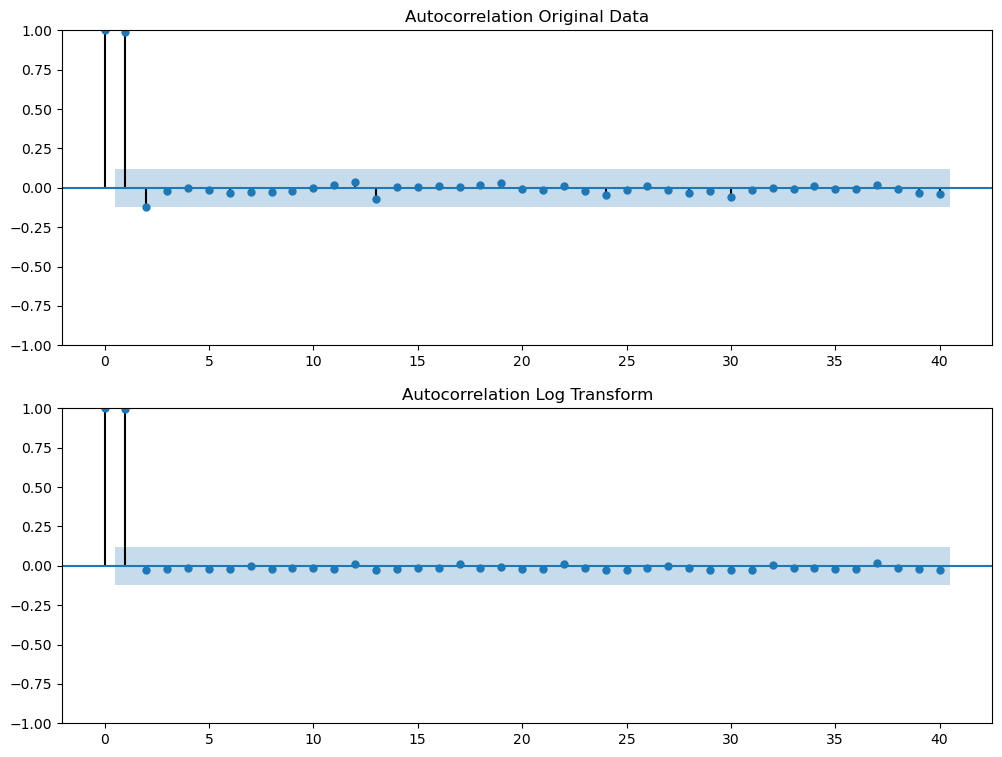

In [11]:
# Partial Autocorrelation check
fig = plt.figure(figsize = (12,9))
ax1 = fig.add_subplot(211)
fig = plot_pacf(x = df, 
               lags=40, 
               ax=ax1)
ax1.title.set_text('Autocorrelation Original Data')
ax2 = fig.add_subplot(212)
fig = plot_pacf(x = np.log(df), 
               lags=40, 
               ax=ax2)
ax2.title.set_text('Autocorrelation Log Transform')

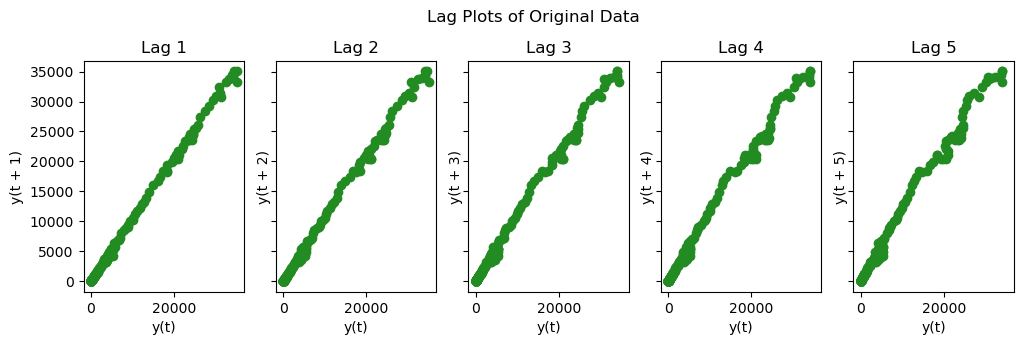

In [12]:
fig, axes = plt.subplots(1, 5, figsize=(12,3), sharex = True, sharey = True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    lag_plot(df['co2'], lag=i+1, ax=ax, c = 'forestgreen')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Original Data', y=1.05)    
plt.show()

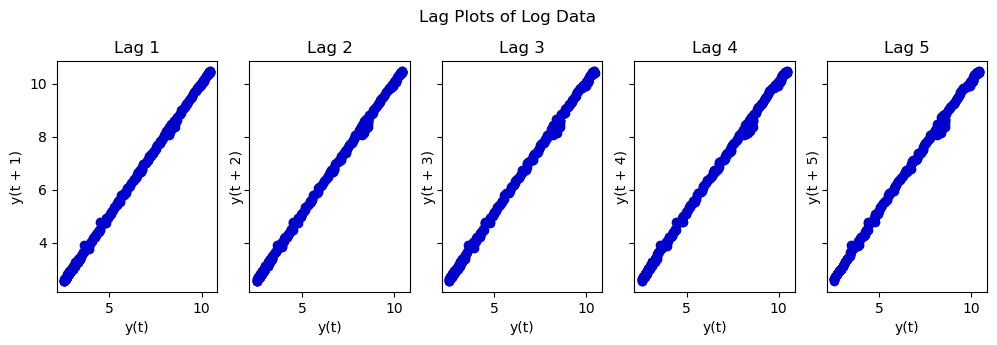

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(12,3), sharex = True, sharey = True, dpi=100)
for i, ax in enumerate(axes.flatten()[:5]):
    lag_plot(np.log(df['co2']), lag=i+1, ax=ax, c = 'mediumblue')
    ax.set_title('Lag ' + str(i+1))

fig.suptitle('Lag Plots of Log Data', y=1.05)    
plt.show()

**Comments:**
- The data is well correlated to its past periods. 
- The data is not stationary. 
- It is necessary to check how many orders of differentiating are necessary to make the data stationary.

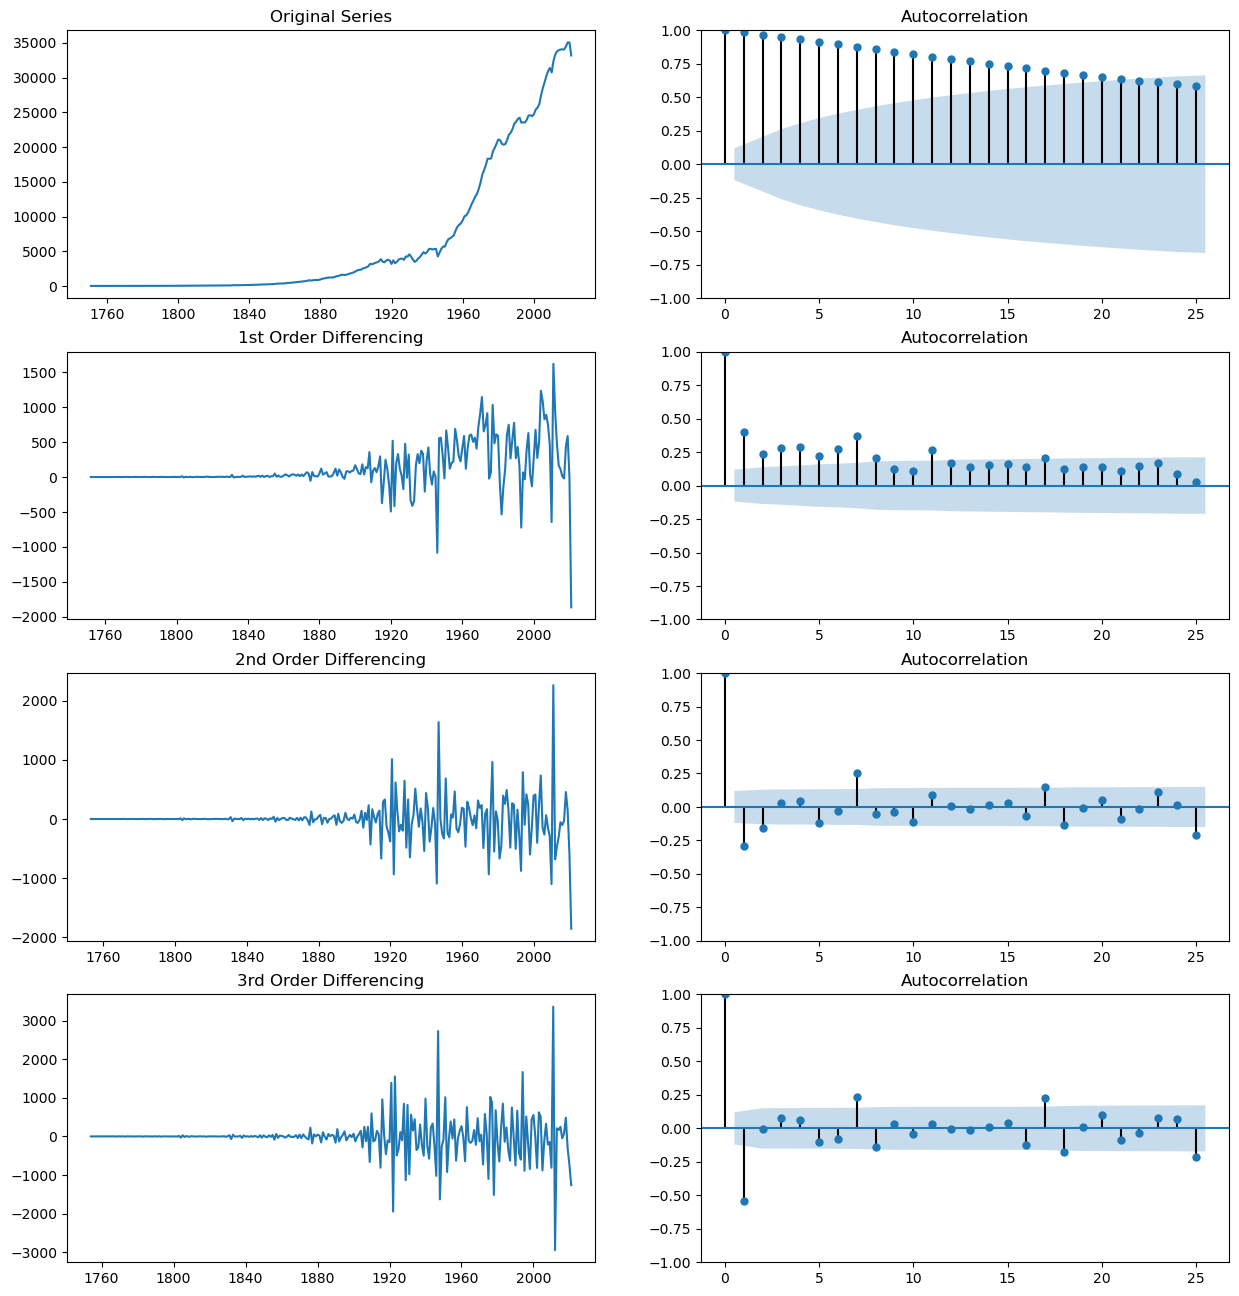

In [14]:
# Check differentiating in original data
fig, axes = plt.subplots(4, 2, figsize = (15,16))

# Original Series
axes[0, 0].plot(df['co2']); axes[0, 0].set_title('Original Series')
plot_acf(df['co2'], ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df['co2'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['co2'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df['co2'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['co2'].diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(df['co2'].diff().diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(df['co2'].diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

In [15]:
# Augmented Dickey-Fuller test for Original Data
result_original = adfuller(df['co2'])
print('ADF Statistic Original: %f' % result_original[0])
print('p-value: %f' % result_original[1])
print('Critical Values:')
for key, value in result_original[4].items():
    print('\t%s: %.3f' % (key, value))
result_original = adfuller(df['co2'].diff()[1:])
print('ADF Statistic Original 1st Dif: %f' % result_original[0])
print('p-value: %f' % result_original[1])
print('Critical Values:')
for key, value in result_original[4].items():
    print('\t%s: %.3f' % (key, value))
result_original = adfuller(df['co2'].diff().diff()[2:])
print('ADF Statistic Original 2nd Dif: %f' % result_original[0])
print('p-value: %f' % result_original[1])
print('Critical Values:')
for key, value in result_original[4].items():
    print('\t%s: %.3f' % (key, value))
result_original = adfuller(df['co2'].diff().diff().diff()[3:])
print('ADF Statistic Original 3rd Dif: %f' % result_original[0])
print('p-value: %f' % result_original[1])
print('Critical Values:')
for key, value in result_original[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic Original: 0.374618
p-value: 0.980521
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
ADF Statistic Original 1st Dif: -2.630514
p-value: 0.086853
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
ADF Statistic Original 2nd Dif: -3.516395
p-value: 0.007576
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
ADF Statistic Original 3rd Dif: -8.315595
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


The original data with a differentiation of 3 shows good statinarity with an ADF Statistic < 1% Critical Value (with a p-value below 5%). Although the differentiation of 2 gives a stationarity with ADF Statistic < 5% Critical Value, it is not quite significant when compared to 1% Critical Value.

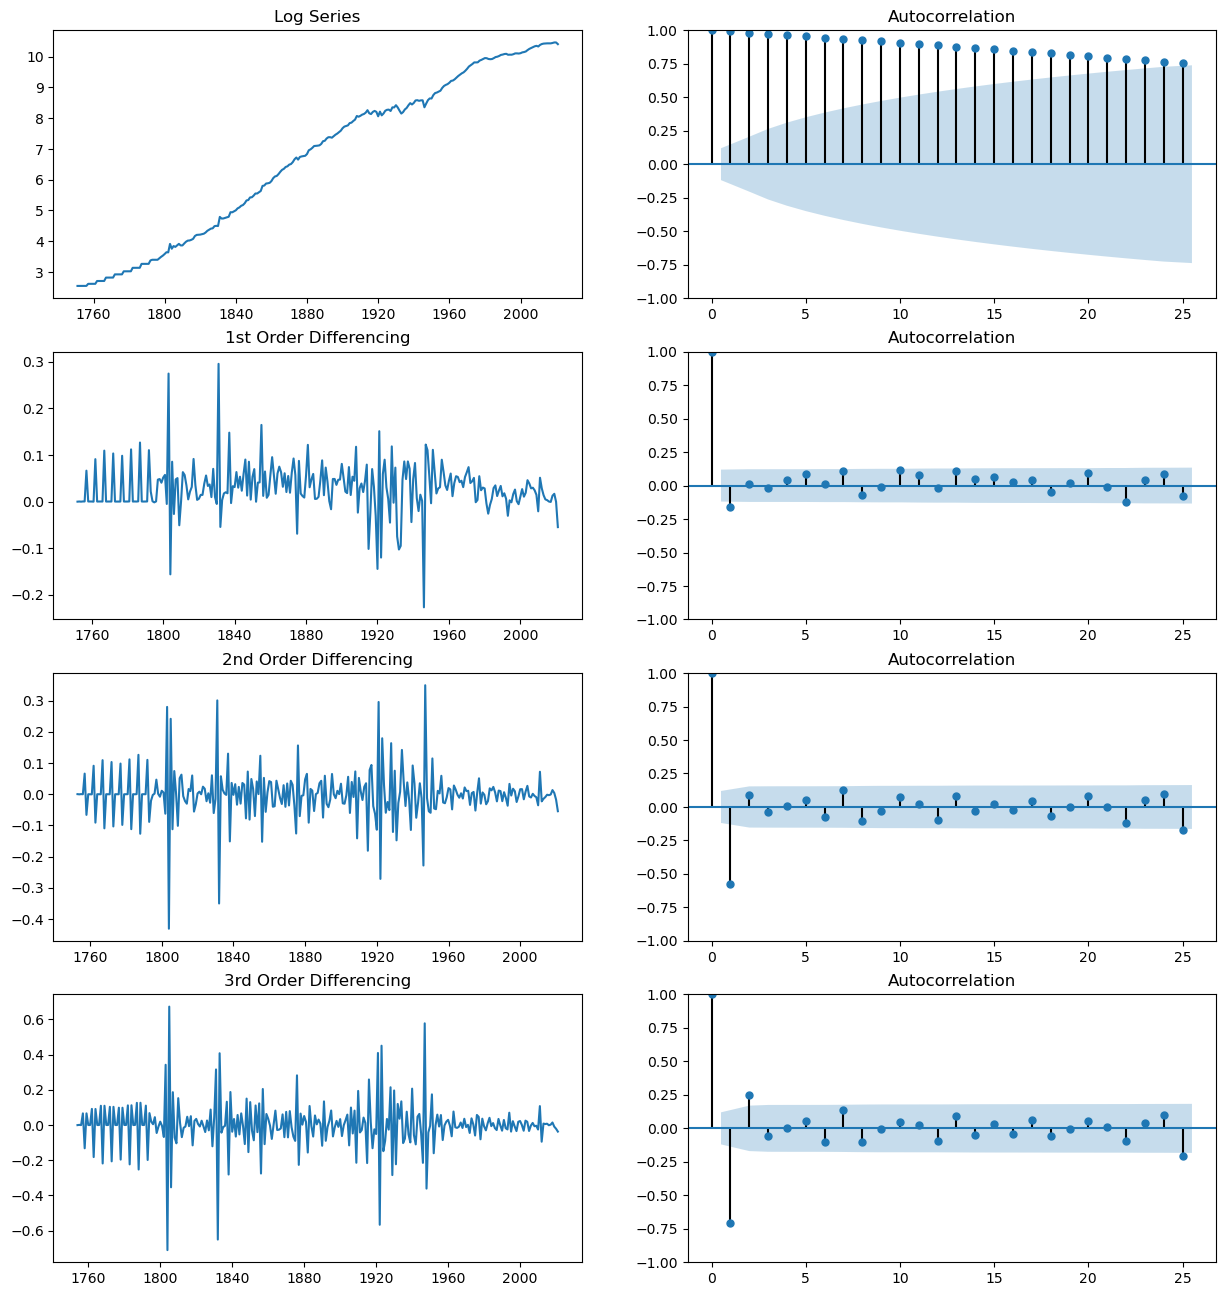

In [16]:
# Check differentiating in log data
fig, axes = plt.subplots(4, 2, figsize = (15,16))

# Original Series
axes[0, 0].plot(np.log(df['co2'])); axes[0, 0].set_title('Log Series')
plot_acf(np.log(df['co2']), ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(np.log(df['co2']).diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.log(df['co2']).diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.log(df['co2']).diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.log(df['co2']).diff().diff().dropna(), ax=axes[2, 1])

# 3rd Differencing
axes[3, 0].plot(np.log(df['co2']).diff().diff().diff()); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(np.log(df['co2']).diff().diff().diff().dropna(), ax=axes[3, 1])

plt.show()

In [17]:
# Augmented Dickey-Fuller test for Log Data
result_log = adfuller(np.log(df['co2']))
print('ADF Statistic Log: %f' % result_log[0])
print('p-value: %f' % result_log[1])
print('Critical Values:')
for key, value in result_log[4].items():
    print('\t%s: %.3f' % (key, value))
result_log = adfuller(np.log(df['co2']).diff()[1:])
print('ADF Statistic Log 1st Dif: %f' % result_log[0])
print('p-value: %f' % result_log[1])
print('Critical Values:')
for key, value in result_log[4].items():
    print('\t%s: %.3f' % (key, value))
result_log = adfuller(np.log(df['co2']).diff().diff()[2:])
print('ADF Statistic Log 2nd Dif: %f' % result_log[0])
print('p-value: %f' % result_log[1])
print('Critical Values:')
for key, value in result_log[4].items():
    print('\t%s: %.3f' % (key, value))
result_log = adfuller(np.log(df['co2']).diff().diff().diff()[3:])
print('ADF Statistic Log 3rd Dif: %f' % result_log[0])
print('p-value: %f' % result_log[1])
print('Critical Values:')
for key, value in result_log[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic Log: -1.145082
p-value: 0.696763
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.573
ADF Statistic Log 1st Dif: -19.107741
p-value: 0.000000
Critical Values:
	1%: -3.455
	5%: -2.872
	10%: -2.573
ADF Statistic Log 2nd Dif: -8.424195
p-value: 0.000000
Critical Values:
	1%: -3.456
	5%: -2.873
	10%: -2.573
ADF Statistic Log 3rd Dif: -9.807675
p-value: 0.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573


The Log data with a differentiation of 1 shows already a good stationarity with an ADF Statistic << 1% Critical Value (with a p-value below 5%). This is also true for the other orders of differentiation. This tells us that the Log transform avoids the need of over-differentiation to make the series stationarity (as it happened with the original data).

**Comments:**
- The 1st order differentiating for the log transform of the data shows good stationarity without "over-differentiation".
- The log transform of the data will be used, as it requires less differentiation to reach stationarity: d = 1.

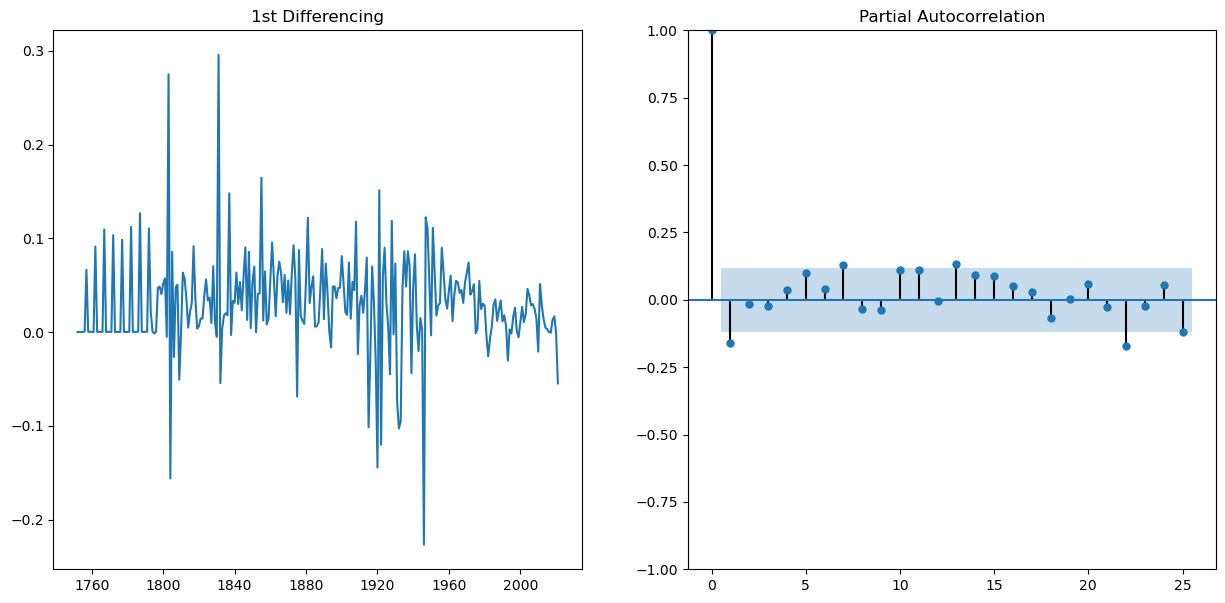

In [18]:
# Partial autocorrelation for Log Data
fig, axes = plt.subplots(1, 2, figsize = (15,7))
axes[0].plot(np.log(df['co2']).diff()); axes[0].set_title('1st Differencing')
axes[1].set(ylim=(0,5))
plot_pacf(np.log(df['co2']).diff().dropna(), ax=axes[1])

plt.show()

**Comments:**
- One order differentiating looks good for the ARIMA model (d = 1)
- One lag is very significant (p = 1)
- A q = 1 is chosen.

## Arima Model

In [19]:
df['logco2'] = np.log(df['co2'])
df.tail()

,co2,logco2
date,,
2016-12-31,34035.382642,10.435156
2017-12-31,34471.811135,10.447897
2018-12-31,35058.007096,10.464759
2019-12-31,35049.914574,10.464528
2020-12-31,33185.793122,10.409877


In [20]:
# ARIMA Model
model = sm.tsa.arima.ARIMA(endog = df['logco2'], order = (1,1,1))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                 logco2   No. Observations:                  271
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 415.919
Date:                Thu, 29 Sep 2022   AIC                           -825.838
Time:                        21:24:50   BIC                           -815.043
Sample:                    12-31-1750   HQIC                          -821.503
                         - 12-31-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9976      0.004    280.907      0.000       0.991       1.005
ma.L1         -0.9668      0.016    -58.918      0.000      -0.999      -0.935
sigma2         0.0027      0.000     23.737      0.0

**Comments:**
- All coefficients are statistically significant, with a p-value < 0.05 (P > |z| values are all 0.000).
- The coefficients are clearly non-zero, since the confidence interval does not include zero in its range for any coefficient.
- A model with order = (1,3,1) can obtain a smaller loglikehood, but this is because of over-differentiating the data (d = 3).
- AIC and BIC criteria show similar results, having a simple and well fitted model.
- The model with d = 1 is kept as the true model, as its residuals are nearly zero and distributed around zero.

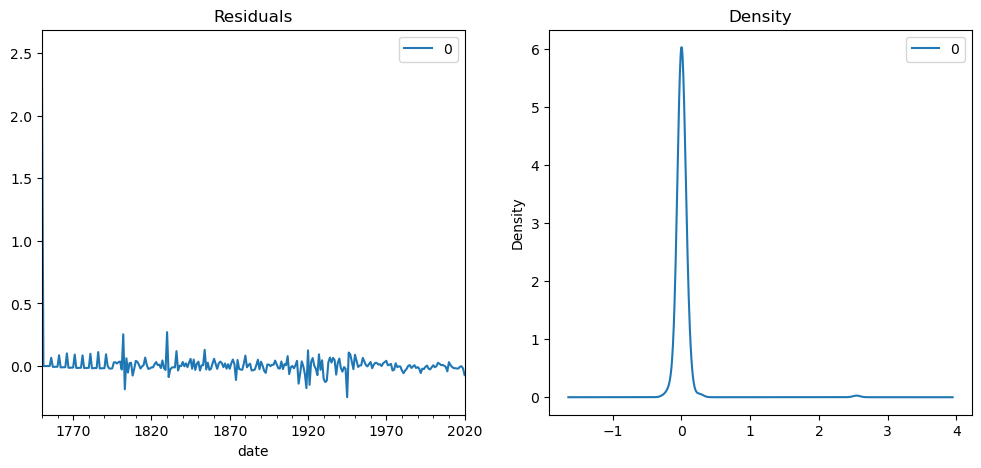

In [21]:
# Plot Residual Errors
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1, 2, figsize = (12,5))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

In [22]:
# Residuals Stats
residuals.describe().T.round(3)

,count,mean,std,min,25%,50%,75%,max
0,271.0,0.012,0.163,-0.249,-0.019,-0.001,0.024,2.546


In [23]:
# Predictions
prediction = model_fit.predict()
predict = model_fit.get_prediction()
predict_ci = predict.conf_int()
predict_ci.describe().T

,count,mean,std,min,25%,50%,75%,max
lower logco2,271.0,-0.637417,119.489594,-1959.963988,4.112142,7.040003,8.750316,10.381343
upper logco2,271.0,14.029756,118.673230,2.652764,4.334629,7.247829,8.975910,1959.963988


In [24]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
co2,271.0,6460.611715,9917.389579,12.760644,67.18982,1221.858624,6977.799809,35058.007096
logco2,271.0,6.708323,2.600054,2.546366,4.20752,7.108128,8.850388,10.464759


In [25]:
forecast_int = model_fit.get_forecast(steps = 10, alpha=0.05)
forecast_val = model_fit.forecast(steps = 10, alpha=0.05)
forecast_int_val = forecast_int.conf_int()
forecast_int_val.tail()

,lower logco2,upper logco2
2026-12-31,10.232213,10.767439
2027-12-31,10.221427,10.807955
2028-12-31,10.211500,10.847541
2029-12-31,10.202211,10.886415
2030-12-31,10.193406,10.924735


In [26]:
# The forecasted values
forecast_val

2021-12-31    10.424960
2022-12-31    10.440005
2023-12-31    10.455015
2024-12-31    10.469988
2025-12-31    10.484925
2026-12-31    10.499826
2027-12-31    10.514691
2028-12-31    10.529520
2029-12-31    10.544313
2030-12-31    10.559071
Freq: A-DEC, Name: predicted_mean, dtype: float64

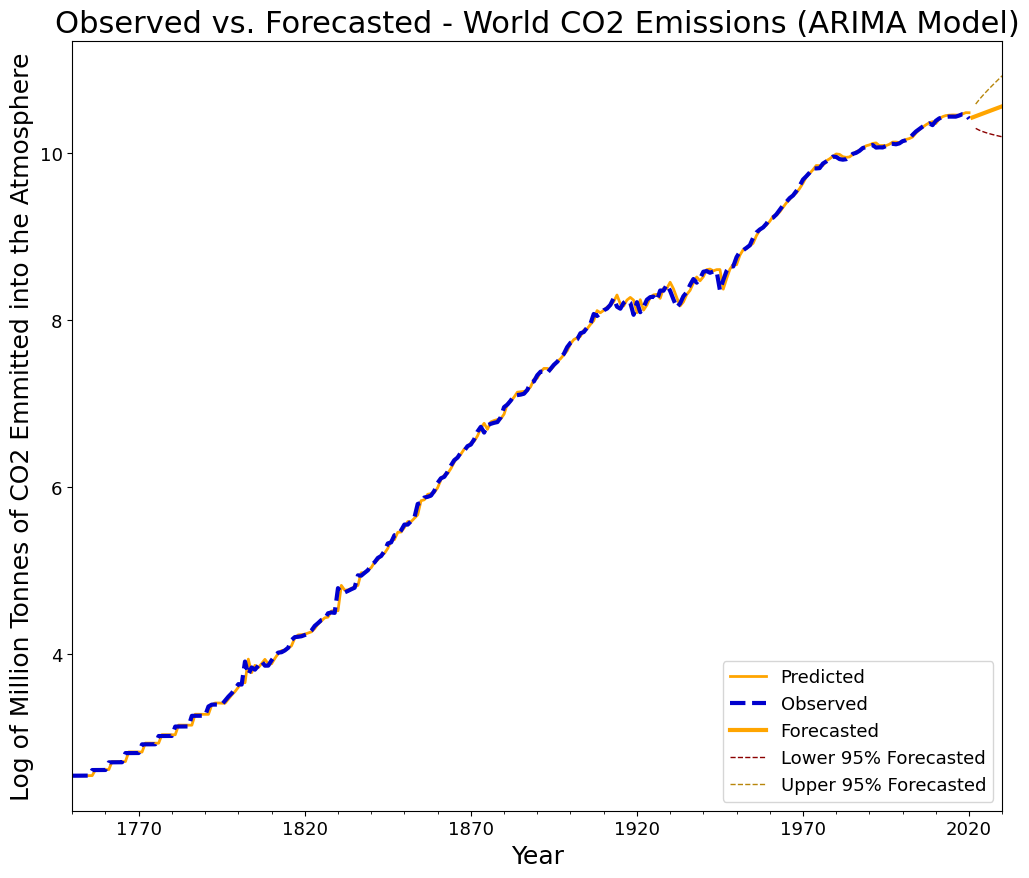

In [27]:
# Actual vs Predicted
fig, ax = plt.subplots(figsize = (12,10))
prediction[1:].plot(linewidth = 2,
               color = 'orange',
               ax = ax,
               label = 'Predicted')
df['logco2'].plot(linewidth = 3, 
                  color = 'mediumblue', 
                  ax = ax, 
                  label = 'Observed',
                  style = '--')
forecast_val.plot(linewidth = 3,
                  color = 'orange', 
                  ax = ax,
                  label = 'Forecasted')
forecast_int_val['lower logco2'].iloc[1:].plot(linewidth = 1, 
                                               color = 'darkred', 
                                               ax = ax, 
                                               label = 'Lower 95% Forecasted',
                                               style = '--')
forecast_int_val['upper logco2'].iloc[1:].plot(linewidth = 1, 
                                               color = 'darkgoldenrod', 
                                               ax = ax, 
                                               label = 'Upper 95% Forecasted',
                                               style = '--')
plt.legend(fontsize = 13, loc = 'lower right')
plt.title('Observed vs. Forecasted - World CO2 Emissions (ARIMA Model)', fontsize = 22)
plt.xlabel('Year', fontsize = 18)
plt.ylabel('Log of Million Tonnes of CO2 Emmitted into the Atmosphere', fontsize = 18)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.show()

## Cross Validation using Mean Absolute Percentage Error (MAPE)

For Cross Validation, the model is re-trained for every year from 1820 to 2020, using as train data all the data prior to each assessed year (From 1750 to the select year of evaluation). This will tell us how the model behaves in bias and variance.

In [40]:
def compute_mape(df):
    errors = []
    for ii in range(70,len(df)):
        X_train = df.index[:ii]
        X_val = df.index[ii]
        y_train = df['logco2'].iloc[:ii]
        y_val = df['logco2'].iloc[ii]
        model = sm.tsa.arima.ARIMA(endog = y_train, order = (1,1,1))
        model_fit = model.fit()
        forecast_val = model_fit.forecast(steps = 1, alpha=0.05)
        errors.append([X_val,100*mean_absolute_error([y_val], [forecast_val[0]])/y_val])
    return errors

In [41]:
errors = compute_mape(df)

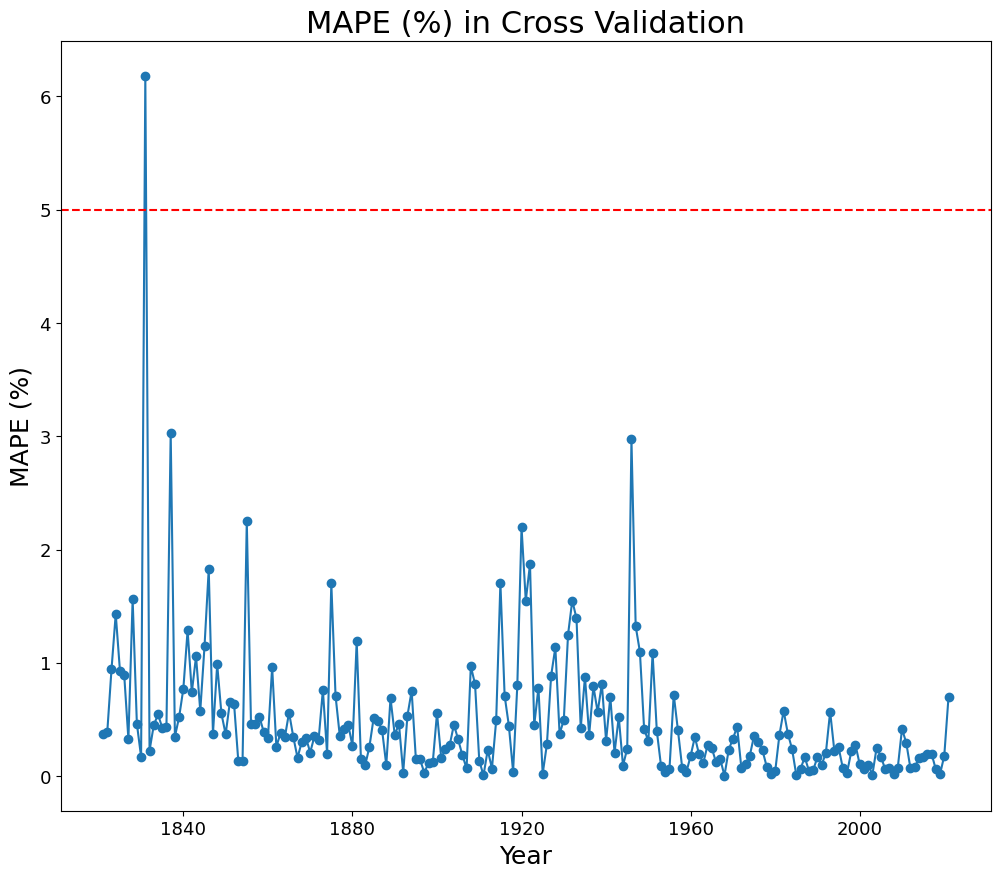

In [42]:
# Plotting the errors
x, y = zip(*errors)
plt.figure(figsize = (12,10))
plt.plot(x, y , 'o-')
plt.axhline(y=5.0, color='r', linestyle='--')
plt.title('MAPE (%) in Cross Validation', fontsize = 22)
plt.xlabel('Year', fontsize = 18)
plt.ylabel('MAPE (%)', fontsize = 18)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.show()

**Comments:**
- The Mean Absolute Error (MAPE) was computed for every year from 1820 to 2020, using as train data all the data prior to each assessed year
- The overall fit of the model is extraordinary, as the MAPE it stays below 5%

## Final Prediction

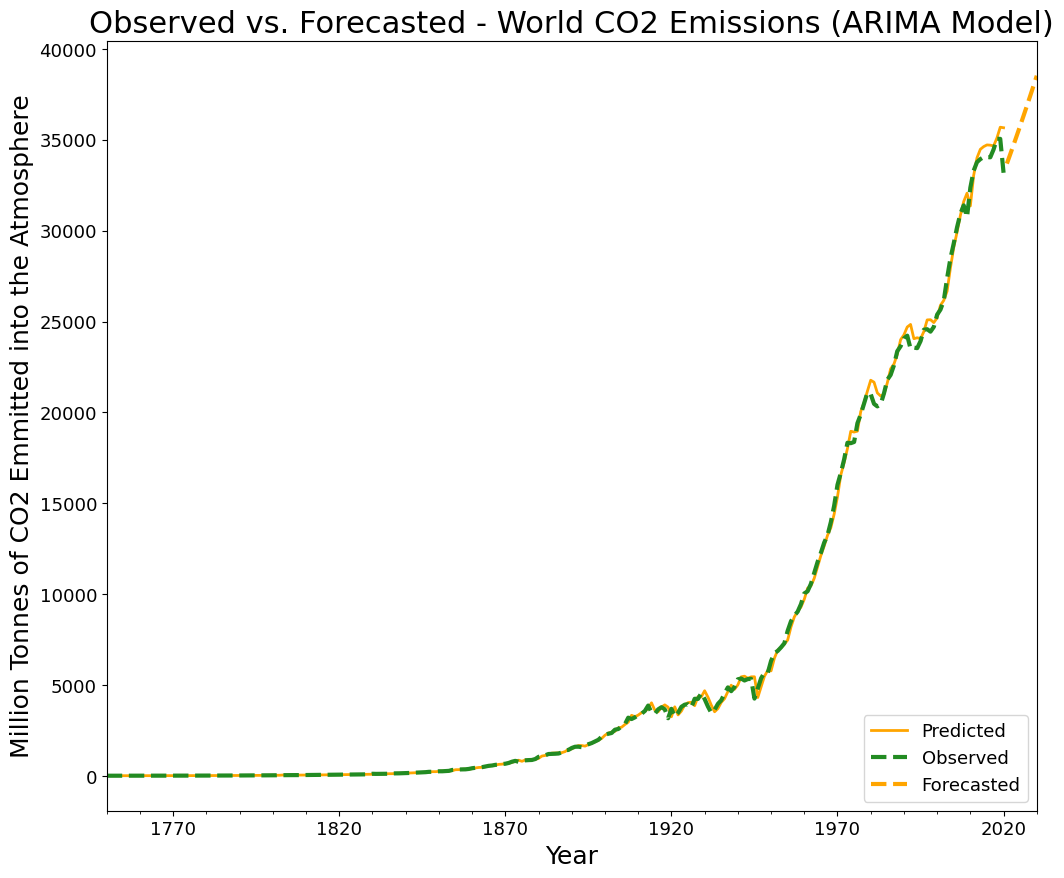

In [31]:
# Actual vs Predicted
fig, ax = plt.subplots(figsize = (12,10))
np.exp(prediction[1:]).plot(linewidth = 2,
                            color = 'orange',
                            ax = ax,
                            label = 'Predicted')
df['co2'].plot(linewidth = 3, 
               color = 'forestgreen', 
               ax = ax, 
               label = 'Observed',
               style = '--')
np.exp(forecast_val).plot(linewidth = 3,
                          color = 'orange', 
                          ax = ax,
                          style = '--',
                          label = 'Forecasted')
plt.legend(fontsize = 13, loc = 'lower right')
plt.title('Observed vs. Forecasted - World CO2 Emissions (ARIMA Model)', fontsize = 22)
plt.xlabel('Year', fontsize = 18)
plt.ylabel('Million Tonnes of CO2 Emmitted into the Atmosphere', fontsize = 18)
plt.xticks(fontsize = 13)
plt.yticks(fontsize = 13)
plt.show()

In [32]:
# 2030 Forecasted Emissions - 2020 Emissions 
em_2030 = forecast_val[-1]
em_2021 = forecast_val[0]
em_2020 = df['logco2'][-1]
exp_2021_2021 = np.exp(em_2021)-np.exp(em_2020)
exp_2030_2020 = np.exp(em_2030)-np.exp(em_2020)
print("For 2021, the model forecasts a cumulative amount of emissions of: {:.1f} Billion Tonnes of CO2".format(np.exp(em_2021)/1000))
print("Between 2021 and 2020, the model forecasts emissions of: {:.1f} Billion Tonnes of CO2".format((exp_2021_2021)/1000))
print("Between 2030 and 2020, the model forecasts emissions of: {:.1f} Billion Tonnes of CO2".format((exp_2030_2020)/1000))

For 2021, the model forecasts a cumulative amount of emissions of: 33.7 Billion Tonnes of CO2
Between 2021 and 2020, the model forecasts emissions of: 0.5 Billion Tonnes of CO2
Between 2030 and 2020, the model forecasts emissions of: 5.3 Billion Tonnes of CO2


## Discussion
- The ARIMA model delivers a good model for the CO2 Emissions data.
- The forecast for the next 10 years exhibit an upward trend, where the CO2 emissions continue to increase over time.
- According to an [IEA article](https://www.iea.org/news/global-co2-emissions-rebounded-to-their-highest-level-in-history-in-2021) the cumulated World's CO2 Emissions in 2021 were 36.3 Billions. The model presented predicts that in 2021, the total emissions were 33.7 Billion tonnes. This represents an understimation of 7.2%.
- Expected CO2 emissions for the next 10 years (Period 2030 - 2021) are: ~ 5.3 Billion Tonnes of CO2.

## Contextualizing the Magnitude of a Tonne of CO2

Many times we are presented to magnitudes that we cannot relate to. Considering that the World CO2 Emissions are a really important magnitude to have into consideration, I recommend the following article by the MIT: [How much is a Tonne of CO2?](https://climate.mit.edu/ask-mit/how-much-ton-carbon-dioxide). This illustrates our impact into this number.